In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

In [3]:
!unzip /content/drive/MyDrive/Map_Data/maps.zip

Archive:  /content/drive/MyDrive/Map_Data/maps.zip
  inflating: train/1.jpg             
  inflating: train/10.jpg            
  inflating: train/100.jpg           
  inflating: train/1000.jpg          
  inflating: train/1001.jpg          
  inflating: train/1002.jpg          
  inflating: train/1003.jpg          
  inflating: train/1004.jpg          
  inflating: train/1005.jpg          
  inflating: train/1006.jpg          
  inflating: train/1007.jpg          
  inflating: train/1008.jpg          
  inflating: train/1009.jpg          
  inflating: train/101.jpg           
  inflating: train/1010.jpg          
  inflating: train/1011.jpg          
  inflating: train/1012.jpg          
  inflating: train/1013.jpg          
  inflating: train/1014.jpg          
  inflating: train/1015.jpg          
  inflating: train/1016.jpg          
  inflating: train/1017.jpg          
  inflating: train/1018.jpg          
  inflating: train/1019.jpg          
  inflating: train/102.jpg           

In [4]:
def define_discriminator(image_shape):
    
	# weight initialization
	init = RandomNormal(stddev=0.02) 
    
	# source image input
	in_src_image = Input(shape=image_shape)  #Image we want to convert to another image
	# target image input
	in_target_image = Input(shape=image_shape)  #Image we want to generate after training. 
    
	# concatenate images, channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
    
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2 
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
   
    
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [5]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block to be used in generator
def decoder_block(layer_in, skip_in, n_filters, dropout=True):

	init = RandomNormal(stddev=0.02)
	
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)

	g = BatchNormalization()(g, training=True)

	if dropout:
		g = Dropout(0.5)(g, training=True)

	g = Concatenate()([g, skip_in])

	g = Activation('relu')(g)
	return g

# define the model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)

	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)

	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)

	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)  
	out_image = Activation('tanh')(g)  
	# define model
	model = Model(in_image, out_image)
	return model


In [6]:
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False      
            
	
	in_src = Input(shape=image_shape)

	gen_out = g_model(in_src)

	dis_out = d_model([in_src, gen_out])

	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
    

	model.compile(loss=['binary_crossentropy', 'mae'], 
               optimizer=opt, loss_weights=[1,100])
	return model


In [7]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [8]:
def summarize_performance(step, g_model, dataset, n_samples=3):

	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)

	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)

	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	
	filename2 = 'model_%06d' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [9]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	
	n_patch = d_model.output_shape[1]
	
	trainA, trainB = dataset
	
	bat_per_epo = int(len(trainA) / n_batch)
	
	n_steps = bat_per_epo * n_epochs

	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

In [10]:
from os import listdir
from numpy import asarray, load
from numpy import vstack
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np


In [11]:
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	
	for filename in listdir(path):
	
		pixels = load_img(path + filename, target_size=size)
	
		pixels = img_to_array(pixels)
		
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


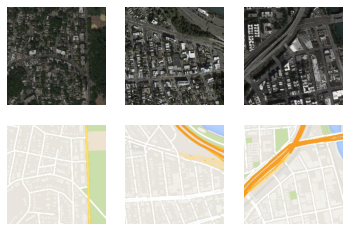

In [12]:

path = '/content/train/'

[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)


n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))

for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [13]:
image_shape = src_images.shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

gan_model = define_gan(g_model, d_model, image_shape)


data = [src_images, tar_images]

def preprocess_data(data):

	X1, X2 = data[0], data[1]
	
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

from datetime import datetime 
start1 = datetime.now() 

train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1) 


stop1 = datetime.now()

execution_time = stop1-start1
print("Execution time is: ", execution_time)


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 17ms/step
>8462, d1[0.009] d2[0.345] g[16.270]
1/1 [==============================] - 0s 20ms/step
>8463, d1[0.012] d2[0.040] g[4.647]
1/1 [==============================] - 0s 19ms/step
>8464, d1[0.170] d2[0.047] g[10.381]
1/1 [==============================] - 0s 18ms/step
>8465, d1[0.327] d2[0.211] g[8.178]
1/1 [==============================] - 0s 20ms/step
>8466, d1[0.251] d2[0.180] g[7.394]
1/1 [==============================] - 0s 21ms/step
>8467, d1[0.018] d2[0.076] g[10.187]
1/1 [==============================] - 0s 29ms/step
>8468, d1[0.033] d2[0.249] g[11.662]
1/1 [==============================] - 0s 25ms/step
>8469, d1[0.657] d2[0.263] g[7.194]
1/1 [==============================] - 0s 22ms/step
>8470, d1[0.019] d2[0.361] g[10.975]
1/1 [==============================] - 0s 22ms/step
>8471, d1[0.119] d2[0.098] g[8.201]
1/1 [==============================] - 0s 18ms/step
>8472, d1[0.

>Saved: plot_010960.png and model_010960
Execution time is:  0:36:02.263448


1/1 [==============================] - 1s 572ms/step


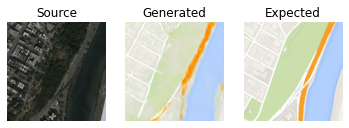

In [14]:
#Test trained model on a few images...

from keras.models import load_model
from numpy.random import randint
model = load_model('/content/model_010960')

# plot source, generated and target images
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))

	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']

	for i in range(len(images)):
		
		pyplot.subplot(1, 3, 1 + i)
		
		pyplot.axis('off')
	
		pyplot.imshow(images[i])
	
		pyplot.title(titles[i])
	pyplot.show()



[X1, X2] = dataset

ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

gen_image = model.predict(src_image)

plot_images(src_image, gen_image, tar_image)